# Interpolate ALOS to daily time-series

#### Inputs:
- ALOS-2 100m stacked 2019 to 2020 data (HH and HV, but starting with HH for proof of concept)
- Actual Evapotranspiration(AET)
- Potential Evapotranspiration (PET)

#### Outputs:
- Daily timeseries of HH, HV and derived indices: HH:HV, RVI on 100m resolution grid
- ALOS SAR stack intensity and decibel versions for use in next codes
- SAR stack statistics for HH, HV, HHHV and RVI
- Net water daily - 1 km grid

#### Daily potential Evapotranspiration: https://earlywarning.usgs.gov/fews/product/81 
- data available from 2001 to 2022
- tar -xzvf to unzip (loop required)
- gdal_translate -of NetCDF {input}.bil {output}.nc
- remove original files to save space
- ncea -d lat,lat_min,lat_max -d lon,lon_min,lon_max input.nc output.nc to cutout to the grid

#### PET vs AET 
 - PET pattern is used here to calculate weightings, and apply them to dekadal AET to produce daily AET
 - then Net Water approximation = daily precip - daily AET (doesn't account for run-off)
 
**Figure 4 in the paper is produced within this code**
 

### Package imports

In [1]:
import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, timedelta
import math
import seaborn as sns

In [ ]:
# Important to set this environment variable so that netcdf files can be opened.
%env HDF5_USE_FILE_LOCKING=FALSE

### Function declarations

In [ ]:
def season_sum(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")


In [ ]:
def reformat_ET(ds,var_name,ds2,lt_map):
    # reversing the lat and lon order to be the same as for the other data
    #ds = ds.reindex(lat = list(reversed(ds.lat)))
    ds = ds.reindex(lon = list(reversed(ds.lon)))

    # interpolating to the same grid as ds2 for comparison
    # this cuts out the required area too
    ds = ds.interp_like(ds2, method='nearest')
    
    # masking for non-peat and nan pixels
    da = ds[var_name].where(lt_map['type'].isin([4,5]))
    da = da.where(~np.isnan(ds2['slope']))
    
    ds = da.to_dataset(name=var_name)
    
    return ds

In [34]:
def norm_to_zero_one(da):
    # a function to normalise xarray data between 0 and 1
    da_new = da.copy()
    for i in range(len(da)):     
        da_new[i] = da[i] - da[i].min() * 1.0 / (da[i].max() - da[i].min())
    return (da_new)

### Data directories

In [28]:
### Declare data and output directories here:



## Calculating net water input dekadal data on the same grid as the re-gridded CHIRPS rainfall and evapotranspiration 1km data

**AET data is available from:** 
- https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/fews/web/africa/dekadal/eta/downloads/
- Also available here as single dekad downloads - could take a while: https://earlywarning.usgs.gov/fews/product/461

In [4]:
# defining the bounds of the Cuvette Centrale region - taken from the veg grid in CHIRPS_AET_calculation_full_CC.ipynb
lat_min = -5.06319436
lat_max = 3.29741657
lon_min = 14.99769448
lon_max = 25.78052774

#### 1. Actual Evapotranspiration (AET) data

In [5]:
# Load the Actual Evapotranspiration data

aet = []
i = 0

# final month we have available data till 
final_month = 7

for yr in range(2015,2022):
    for mo in range(1,13):
        
        # breaking out of loop if most recent available data is before the end of the final year in loop
        
        if yr == 2021:
            if mo == 7:
                break
        
        mo = str(mo).zfill(2)
        for d in range(1,4):
            i = i+1
            ds2 = xr.open_rasterio(AET + 'd' + str(yr) + mo + str(d) +'_modisSSEBopETv4_actual_mm.tif')
                        
            # renaming x and y dimensions to the same as the ALOS imagery
            ds2 = ds2.rename({'x': 'lon','y': 'lat'})
        
            # cutting out to ALOS image size
            im = ds2.where((lon_min < ds2.lon) & (ds2.lon < lon_max) & (lat_min < ds2.lat) & (ds2.lat < lat_max), drop=True)            

            # setting no values (currently 255.0) to nan
            im = im.where(im != 255., drop=True)   # cut out first   
            
            im = im.to_dataset(dim='band')
            
            # converting to pandas dataframe to change column name of the data variable to a string
            df = im.to_dataframe()

            # converting column names to something more representative
            a = ['aet']
            df.columns = a
            #print (df)

            # converting back to xarray
            im = df.to_xarray()
            
            # appending each image to the array of all evapotranspiration data
            aet.append(im) 
            


In [6]:
# creating the new 1km grid that will be common between the net water and chirps daily data
# re-sampling from 0.05 to 0.01 degrees
# applying a shift value to create a grid with edge pixels within half the original chirps resolution (0.05) this means null value edge pixels can be avoided

shift = 0.0255
ds_out_1km = xr.Dataset({'lat': (['lat'], np.arange(lat_min + shift, lat_max - shift, 0.01)),
                     'lon': (['lon'], np.arange(lon_min + shift, lon_max - shift, 0.01)),
                    }
                   )
ds_out_1km

<xarray.Dataset>
Dimensions:  (lat: 831, lon: 1074)
Coordinates:
  * lat      (lat) float64 -5.038 -5.028 -5.018 -5.008 ... 3.242 3.252 3.262
  * lon      (lon) float64 15.02 15.03 15.04 15.05 ... 25.72 25.73 25.74 25.75
Data variables:
    *empty*

In [7]:
# creating the new grid to be applied to all of the data within the aet array
# using nearest neighbour method as just slightly regridding 1km data to 1km shifted grid
regridder_aet_1km = xe.Regridder(aet[0], ds_out_1km, 'nearest_s2d')
regridder_aet_1km  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_866x1117_831x1074.nc 
Reuse pre-computed weights? False 
Input grid shape:           (866, 1117) 
Output grid shape:          (831, 1074) 
Periodic in longitude?      False

/home/s0677837/Datastore/miniconda3/envs/congo3/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


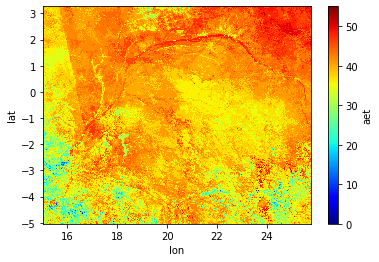

In [8]:
# now regridding the dataset and plotting
# regridding before appending the data to the final array as there seems to be some mis-alignment of the data 
# that requires correcting before the images can be stacked correctly.
aet2 = []
for i in range(len(aet)):
    aet2.append(regridder_aet_1km(aet[i]['aet']))
    
aet2[0].plot()

In [ ]:
# creating an array of datetimes corresponding with each image - an array of the start dates of each dekad
days = ['01','11','21']
dekad_dates = []

for yr in range(2015,2022):
    for mo in range(1,13):
        mo = str(mo).zfill(2)
        for d in range(1,4):
            
            # appending the start date of each dekad to an array
            dekad_dates.append(str(yr) + '-' + mo + '-' + days[d-1])      

# converting dekad_dates to the datetime format required for dataframes
dekad_dates = pd.to_datetime(dekad_dates)
print (dekad_dates)

In [10]:
# full aet data is from 2014 to June 2021
# concatecating only data from 2015 to end of dekad_dates
#aet_d = xr.concat(aet2[36:], pd.Index(dekad_dates[:-18], name="time"))   # use this is data is read in from 2014+

aet_d = xr.concat(aet2[:], pd.Index(dekad_dates[:-18], name="time"))


#### 2. Potential evapotranspiration (PET) data

**PET data source:**
- https://earlywarning.usgs.gov/fews/product/81
- daily, 1 degree resolution

In [ ]:
# creating the new 1km grid that will be common between the ET/PET, net water and chirps daily data
# re-sampling from 1.0 to 0.01 
# creating a grid with edge pixels within half the original chirps resolution (0.05) to avoid null value edge pixels

shift = 0.0255
ds_out_1km_PET = xr.Dataset({'lat': (['lat'], np.arange(lat_min + shift, lat_max - shift, 0.01)),
                     'lon': (['lon'], np.arange(lon_min + shift, lon_max - shift, 0.01)),
                    }
                   )
ds_out_1km_PET

In [12]:
# reading in the data 2019 to 2022
PET_daily = []

# date generator function
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

for yr in range(2015,2022):
    
    end_date = date(yr+1,1,1)
    start_date = date(yr,1,1)
    
    # opening the daily PET file (1 degree resolution)
    for single_date in daterange(start_date, end_date):
        date_str = single_date.strftime("%Y%m%d")
        #print(date_str)
        
        #print(PET_dir + '/pet_' + str(yr) +'/Congo_et' + date_str + '.nc')
        ds = xr.open_dataset(PET_dir + '/pet_' + str(yr) +'/Congo_et' + date_str + '.nc')
        
        # cutting out the region to match the net water product extent
        #im = ds.where((lon_min < ds.lon) & (ds.lon < lon_max) & (lat_min < ds.lat) & (ds.lat < lat_max), drop=True)  

        # setting no values (currently -9999.0) to nan
        im = ds.where(ds != -9999., drop=True) 
        
        PET_daily.append(im) 


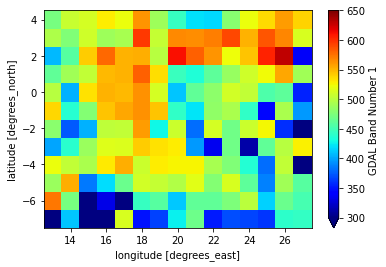

In [13]:
PET_daily[100]['Band1'].plot(vmin=300,vmax=650)

In [14]:
# creating the new grid to be applied to all of the data within the aet array
# using nearest neighbour method as just slightly regridding 1km data to 1km shifted grid
regridder_pet_1km = xe.Regridder(PET_daily[0], ds_out_1km_PET, 'bilinear')
#regridder_pet_1km = xe.Regridder(PET_daily[0], ds_out_1km_PET, 'nearest_s2d')
regridder_pet_1km  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_12x15_831x1074.nc 
Reuse pre-computed weights? False 
Input grid shape:           (12, 15) 
Output grid shape:          (831, 1074) 
Periodic in longitude?      False

In [ ]:
%%time
# now regridding the dataset and plotting
# regridding before appending the data to the final array as there seems to be some mis-alignment of the data 
# that requires correcting before the images can be stacked correctly.
PET = []
for i in range(len(PET_daily)):
    PET.append(regridder_pet_1km(PET_daily[i]['Band1']))

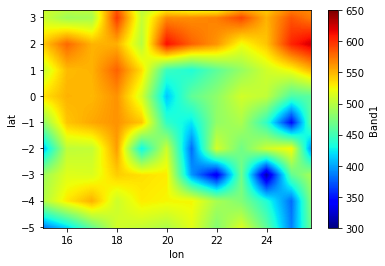

In [16]:
  PET[100].plot(vmin=300,vmax=650)

#### 3. Calculating weightings of PET_daily to PET_dekadal

In [17]:
## First, calculating the pixel by pixel standard deviations between dekadal PET and dekadal AET
## permanently flooded regions will have lowest differences and standard deviations. 

ET_diffs = []

# looping over the dekadal periods, taking into account how many days are in each dekad 
# for the period corresponding with dekad_dates
for i in range(len(aet_d)):
    start = i*10
    end = start + (dekad_dates[i+1]-dekad_dates[i]).days
    #print (i,start, end)
    
    # Dividing by 100 as the PET daily data was scaled up by 100 so that its 
    # accuracy could be to 0.01 mm in integer format
    PET_dek = sum(PET[start:end])/100.0
    ET_diffs.append(PET_dek - aet_d[i])

# converting the array of diffs into an xarray
ET_diffs_ds = xr.concat(ET_diffs[:], pd.Index(dekad_dates[:-18], name="time"))

In [ ]:
# creating an array of daily datetimes corresponding

sdate = date(2015, 1, 1)   # start date
edate = date(2021, 12, 31)   # end date

delta = edate - sdate       # as timedelta

daily_dates = []

for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    daily_dates.append(day)

daily_dates = pd.to_datetime(daily_dates)

print (daily_dates)

In [19]:
## Calculating the distribution of PET_daily in relation to PET_dek (10 days)

# creating an array of daily images of weightings of daily chirps data compared to dekadal
PET_weights = []

# the final daily AET product to be created using the calculated weightings
AET_daily = []

# the dekads array should cover the same range of dates as the aet, chirps dekad and chirps daily data
# -18 is used due to the current data only being available till end of June 2021
total_dekads = len(dekad_dates[:-18])

# final xarrays: chirps_daily, net_water, chirps_d, aet_d
# calculating the fractional contribution of each day's rainfall to the dekadal totals
daily_index = 0
for i in range(len(dekad_dates[:-18])):
#for i in range(216):
    dekad_start = dekad_dates[i]
    #print (dekad_start)
    dekad_day = dekad_dates[i].day
    dekad_m = dekad_dates[i].month
    dekad_yr = dekad_dates[i].year
    
    # correcting for the last dekad containing a variable number of days
    if dekad_day == 21:
        dekad_days_total = monthrange(dekad_yr, dekad_m)[1] - dekad_day + 1

        # dekad 3 (variable days)
        for j in range(dekad_days_total): 
            current_date = daily_dates[daily_index]
            #print (current_date)
            
            # Multiplying by 0.01 as the PET daily data was scaled up by 100 so that its 
            # accuracy could be to 0.01 mm in integer format
            weighting = 0.01*PET[daily_index]/PET_dek
            PET_weights.append(weighting) 
            
            # applying weights to AET dekadal to calculate AET daily
            AET_daily.append(aet_d[i]*weighting)

            #print (dekad_start, daily_index, current_date)
            daily_index = daily_index + 1
    else: 
        # dekads 1 or 2
        for j in range(10):
            current_date = daily_dates[daily_index]
            #print (current_date)
            weighting = 0.01*PET[daily_index]/PET_dek
            PET_weights.append(weighting) 
            
            # applying weights to AET dekadal to calculate AET daily
            AET_daily.append(aet_d[i]*weighting)

            #print (dekad_start, daily_index, current_date)
            daily_index = daily_index + 1

            


#### 4. Converting the AET daily array to an xarray for use in calculating the daily net water input

In [20]:
# make sure that the length of AET daily and daily_dates match if extending the timeframe (we don't require the last 
# 184 time steps in this case)
aet_daily = xr.concat(AET_daily[:], pd.Index(daily_dates[:-184], name="time"))
#aet_daily

In [21]:
# now applying a scaling factor to aet_daily to bring it in line with the AET dekadal total

for i in range(len(aet_d)):
    start = i*10
    end = start + (dekad_dates[i+1]-dekad_dates[i]).days
    #print(i,start,end)
    aet_daily_new = aet_daily[start:end].copy()
    scaling = aet_d[i]/sum(aet_daily[start:end])
    aet_daily[start:end] = aet_daily_new[:] * scaling

#### 5. Investigating seasonal differences between the PET and AET

In [22]:
# Investigating the seasonal differences
month_length = ET_diffs_ds.time.dt.days_in_month
#month_length

ET_diffs_season = season_sum(ET_diffs_ds, calendar="standard")


### Analysing the seasonal differences between dekadal PET and AET
- small differences mean that the daily PET pattern can effectively be used to interpolate the dekadal AET data to daily

In [23]:
ET_diffs_season_ds = ET_diffs_season.to_dataset(name='ET diffs')
ET_diffs_season_ds

<xarray.Dataset>
Dimensions:   (lat: 831, lon: 1074, season: 4)
Coordinates:
  * lon       (lon) float64 15.02 15.03 15.04 15.05 ... 25.72 25.73 25.74 25.75
  * lat       (lat) float64 -5.038 -5.028 -5.018 -5.008 ... 3.242 3.252 3.262
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    ET diffs  (season, lat, lon) float64 10.9 11.03 11.28 ... 7.484 7.435 6.301

In [25]:
ALOS_OUT = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/ALOS_nc/'

# land type map
lt_map = xr.open_dataset(ALOS_OUT + 'landtype_100m.nc')

# pixel wise correlation slope data
pw_slopes = xr.open_dataset(ALOS_OUT + 'slopes_da_HH_new.nc')
test = pw_slopes.to_array().to_dataset(name='slope')
pw_slopes = test['slope'][0][0].to_dataset(name='slope')
pw_slopes = pw_slopes.where(lt_map['type'].isin([4,5]))

ET_diffs_ds = reformat_ET(ET_diffs_season_ds,'ET diffs',pw_slopes,lt_map)
ET_diffs_ds

<xarray.Dataset>
Dimensions:   (lat: 4275, lon: 4214, season: 4)
Coordinates:
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lat       (lat) float64 -1.081 -1.08 -1.079 -1.078 ... 2.757 2.758 2.759
  * lon       (lon) float64 16.12 16.12 16.12 16.12 ... 19.9 19.9 19.9 19.9
    variable  <U29 '__xarray_dataarray_variable__'
Data variables:
    ET diffs  (season, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [26]:
ET_diffs_ds = ET_diffs_ds.rename({'ET diffs':'Seasonally accumulated differences between 10-day PET and AET totals (mm)'})


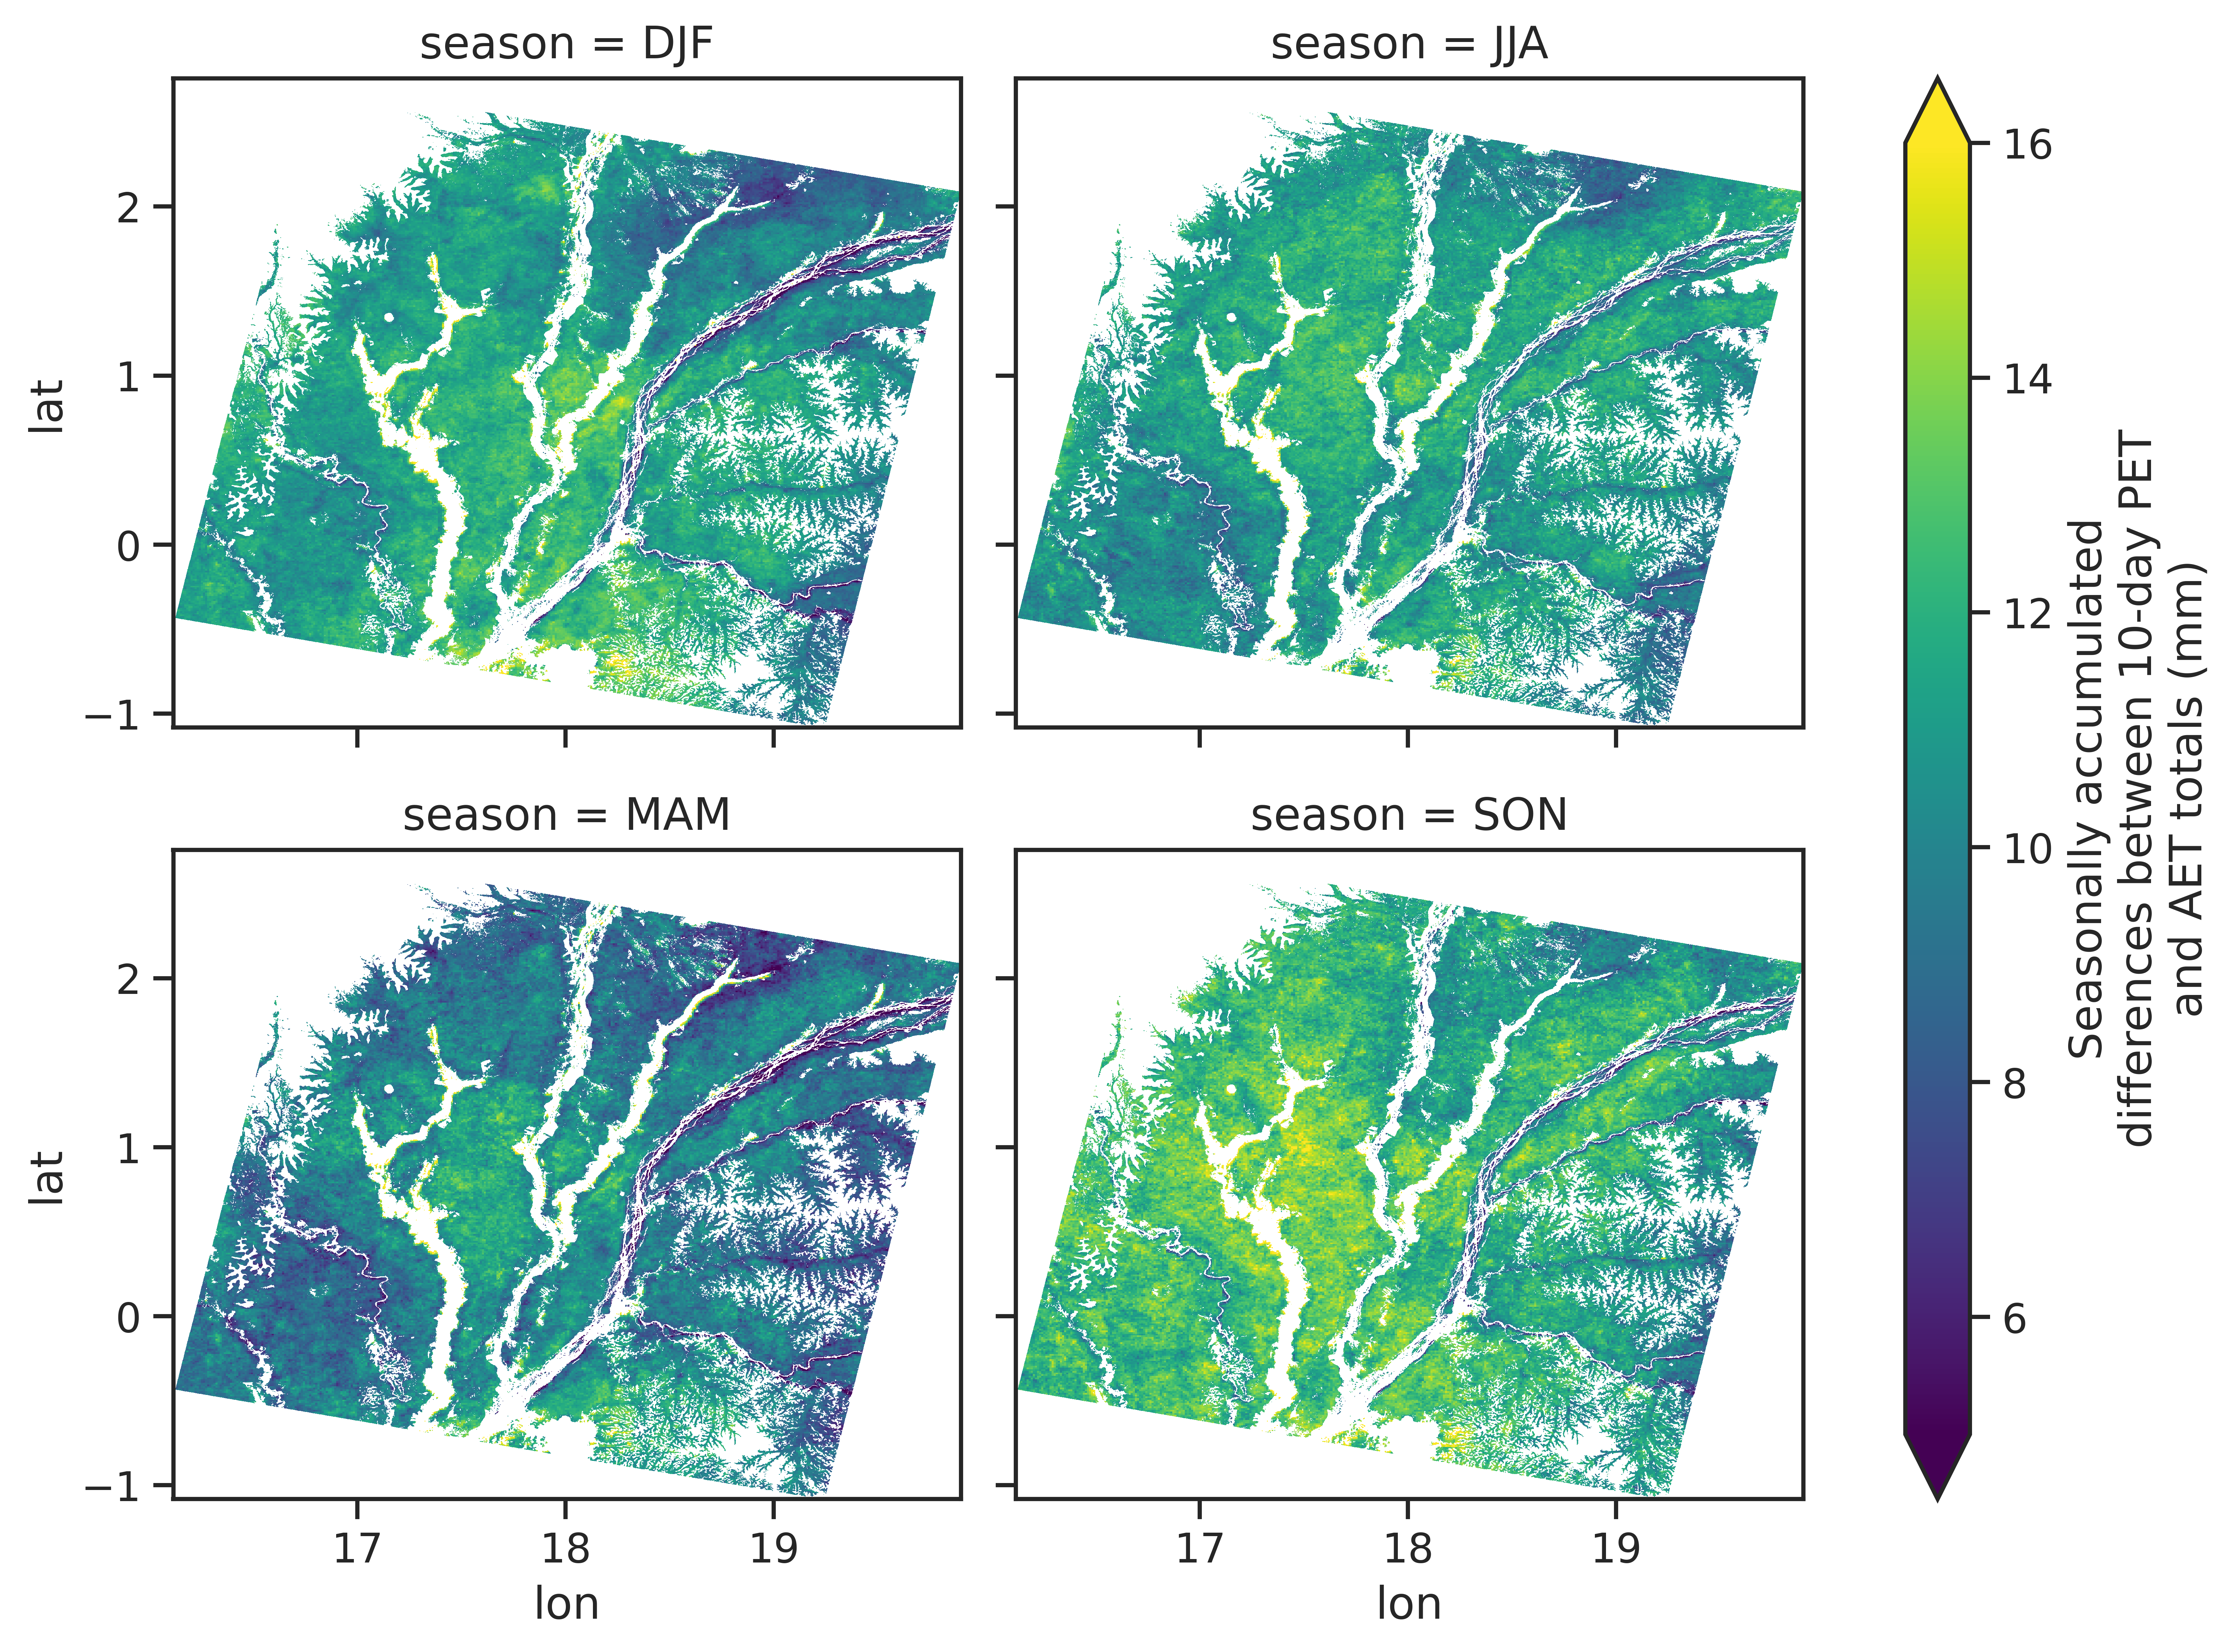

In [27]:
plt.rcParams['figure.dpi'] = 700
sns.set(font_scale=1.1, rc={'axes.facecolor':'white'}, style='ticks')
ET_diffs_ds['Seasonally accumulated differences between 10-day PET and AET totals (mm)'].plot(col='season',col_wrap=2,cmap='viridis', vmin=5, vmax = 16, size=3.5, aspect=1.2)
plt.savefig(images + 'ET_diffs.png')

In [58]:
# calculating the difference between the 10-day (dekadal) PET and AET totals by season
for i in range(4):
    print (np.round(ET_diffs_ds['Seasonally (3-month) accumulated differences between 10-day PET and AET totals'][i].mean().values,1))
    
print ('Overall mean difference: ' + str(np.round(ET_diffs_ds['Seasonally (3-month) accumulated differences between 10-day PET and AET totals'].mean().values)))
 

11.0
11.0
9.6
12.0
Overall mean difference: 11.0


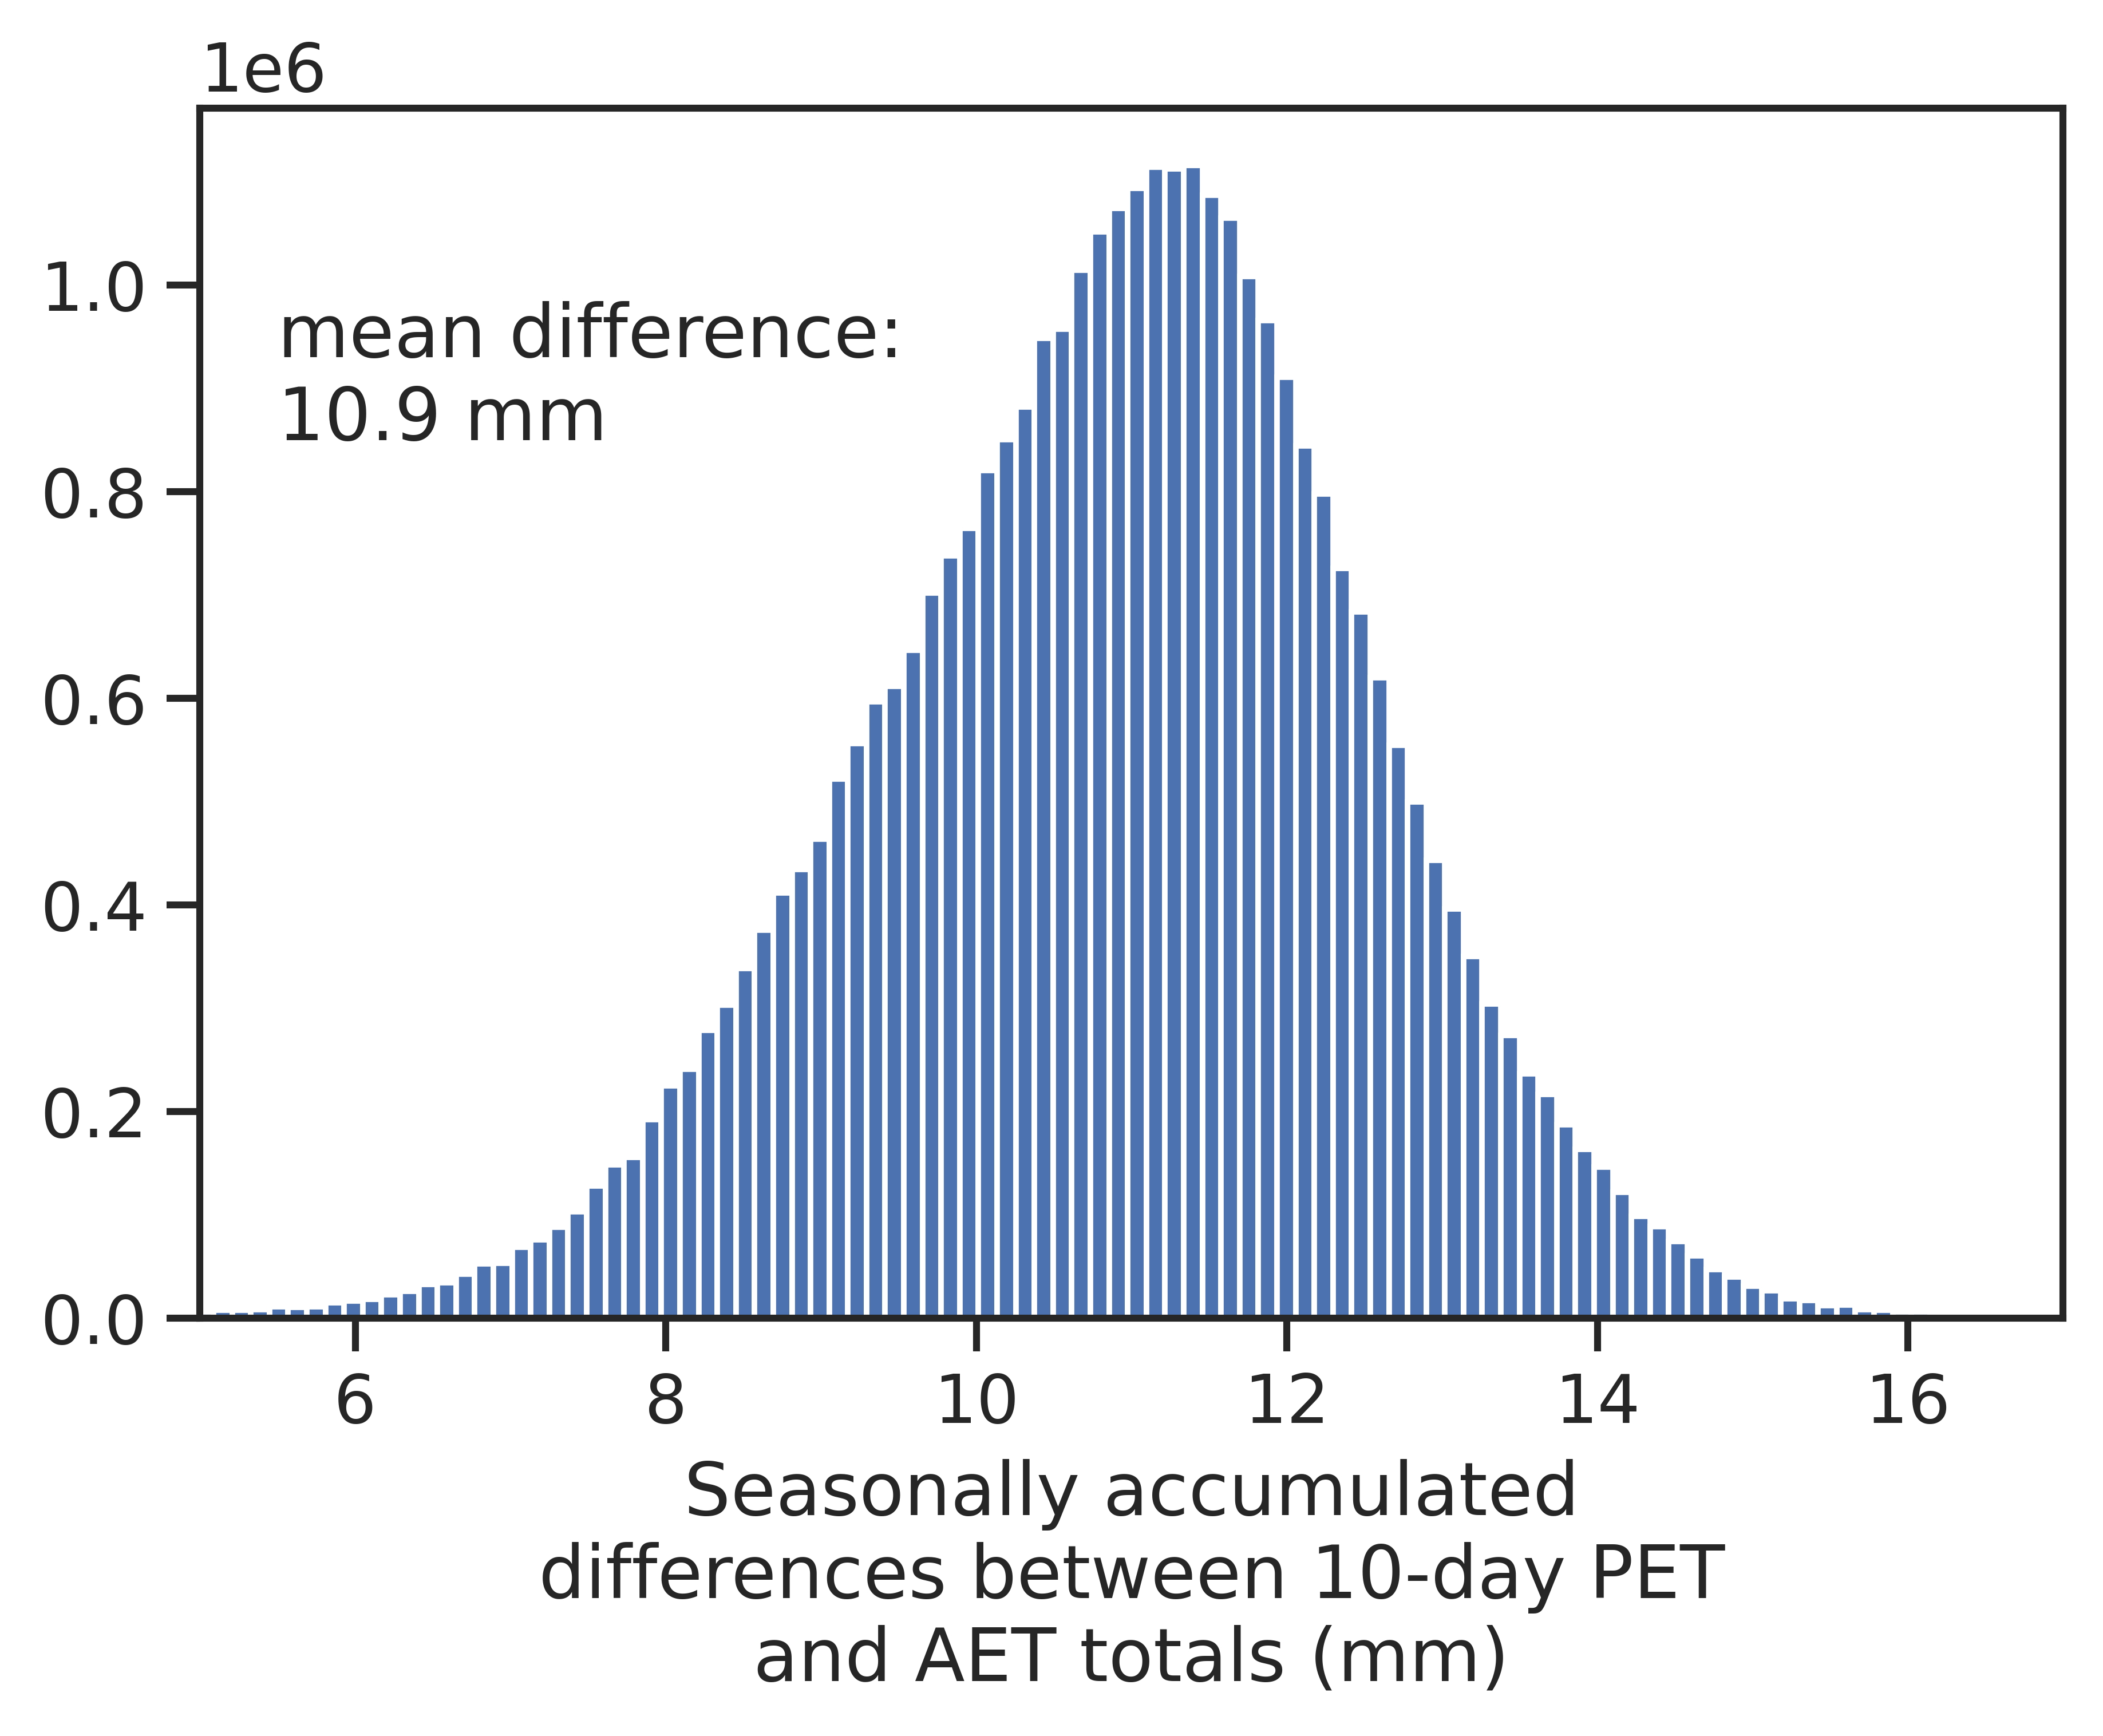

In [73]:
images = '/home/s0677837/Datastore/PHD/Reports/Flood_map_paper/GHG_images/'
ET_diffs_ds['Seasonally accumulated differences between 10-day PET and AET totals (mm)'].plot.hist(bins=200, xlim=(5,17));
plt.title('')
mean_diff = ET_diffs_ds['Seasonally accumulated differences between 10-day PET and AET totals (mm)'].mean().values
plt.text(5.5,850000,'mean difference: \n' +str(np.round(mean_diff,1)) + ' mm' )
plt.savefig(images + 'ET_diffs_hist.png', bbox_inches='tight')

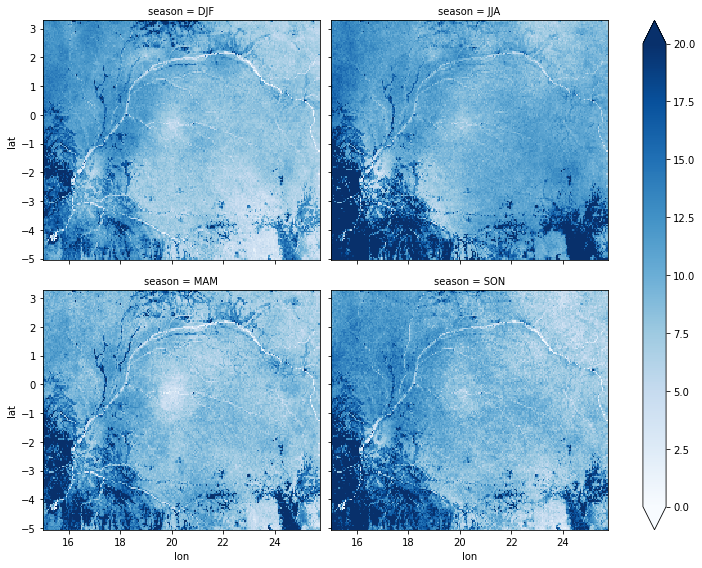

In [50]:
ET_diffs_season[:,::5,::5].plot(col='season',col_wrap=2,cmap='Blues',vmin=0,vmax=20.0, size=4, aspect=1.2)

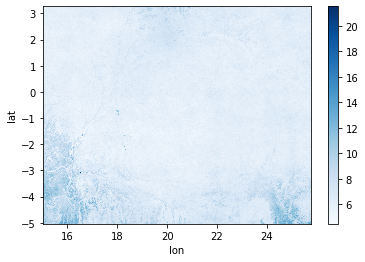

In [24]:
ET_diffs_ds.std(dim='time').plot(cmap='Blues')

## CHIRPS daily data

In [27]:
# reading in the data 2015 to 2022
chirps_daily1 = []

for yr in range(2015,2022):
    ds = xr.open_dataset(Chirps_daily + 'chirps-v2.0.' + str(yr) + '.days_p05.nc')
        
    # renaming x and y dimensions to the same as the ALOS imagery and net water products
    ds = ds.rename({'longitude': 'lon','latitude': 'lat'})
    
    # cutting out the region to match the net water product extent
    im = ds.where((lon_min < ds.lon) & (ds.lon < lon_max) & (lat_min < ds.lat) & (ds.lat < lat_max), drop=True)  
    
    # setting no values (currently -9999.0) to nan
    im = im.where(im != -9999., drop=True)   

    # appending the cutout images to the chirps_daily array
    chirps_daily1.append(im)
    

In [28]:
# merging the chirps daily data into a single xarray along the time dimension
chirps_daily_ds = xr.concat(chirps_daily1,dim='time')

In [30]:
# creating the new grid to be applied to all of the data within the aet array
regridder = xe.Regridder(chirps_daily_ds, ds_out_1km, 'bilinear')
regridder  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_167x216_831x1074.nc 
Reuse pre-computed weights? False 
Input grid shape:           (167, 216) 
Output grid shape:          (831, 1074) 
Periodic in longitude?      False

In [ ]:
# regridding to the same grid as the dekadal chirps and aet data
# regridding the chirps array to the new grid
chirps_daily = regridder(chirps_daily_ds['precip'])
#chirps_daily

#### Daily Net water calculation

In [32]:
# calculate net water daily, taking into account the range of dates the data is available over 
# (currently till June 2021)
nw_daily = chirps_daily[:-184] - aet_daily
#nw_daily

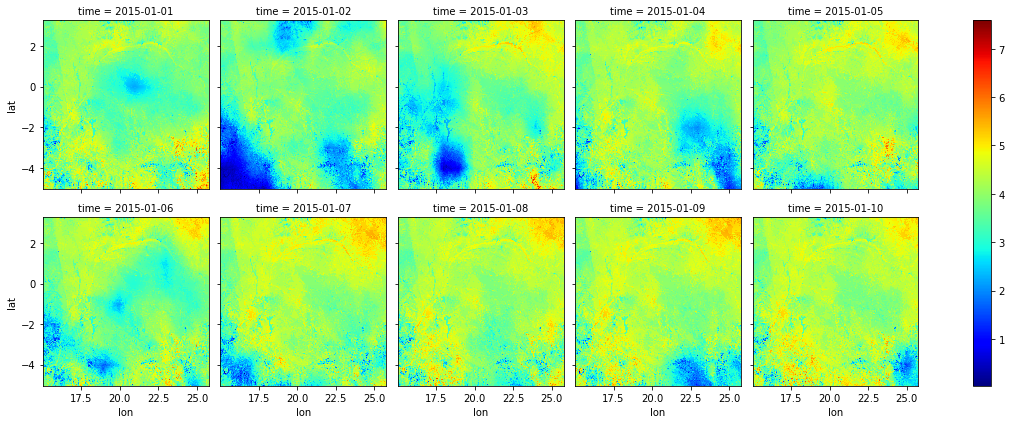

In [29]:
aet_daily[0:10].plot(col='time',col_wrap=5,)

In [90]:
# Saving nw_daily to a PKL file for quickstart option below (comparisons with the SAR data)
with open(PKL + 'nw_daily.pkl', 'wb') as handle:
    pkl.dump(nw_daily, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [33]:
# saving nw_daily as a netcdf file as saving as pkl seems to lose some of the cf conventions necessary for regridding
nw_daily.to_netcdf(path=ALOS_OUT + 'nw_daily.nc')

### Calculating daily weightings to be applied to the dekadal net water product - no longer required as PET weightings used instead

#### 1. organising the dekadal CHIRPS data

In [ ]:
# reading in CHIRPS dekadal data 
# This is on the same 1km grid as the daily data

# an array to contain all of the dekadal chirps data
chirps = []

# creating an array of datetimes corresponding with each image - an array of the start dates of each dekad
days = ['01','11','21']
dekad_dates = []

for yr in range(2015,2022):
    for mo in range(1,13):
        mo = str(mo).zfill(2)
        for d in range(1,4):
            
            # appending the start date of each dekad to an array
            dekad_dates.append(str(yr) + '-' + mo + '-' + days[d-1])
            
            # opening each image
            ds = xr.open_rasterio(Chirps + 'chirps-v2.0.' + str(yr) + '.' + mo + '.' + str(d) + '.tif')
            
            # renaming x and y dimensions to the same as the ALOS imagery
            ds = ds.rename({'x': 'lon','y': 'lat'})
        
            # cutting out to ALOS image size
            im = ds.where((lon_min < ds.lon) & (ds.lon < lon_max) & (lat_min < ds.lat) & (ds.lat < lat_max), drop=True)            

            # setting no values (currently -9999.0) to nan
            im = im.where(im != -9999., drop=True)   
            
            # converting from DataArray to Dataset format
            im = im.to_dataset(dim='band')
            
            # converting to pandas dataframe to change column name of the data variable to a string
            df = im.to_dataframe()

            # converting column names to something more representative of the data
            a = ['precip']
            df.columns = a
            #print (df)

            # converting back to xarray
            im = df.to_xarray()
            #print (im)
            
            # appending each dekadal image to the array of all images
            chirps.append(im)            


# converting dekad_dates to the datetime format required for dataframes
dekad_dates = pd.to_datetime(dekad_dates)
print (dekad_dates)

# the final chirps dekadal array, indexed by datetime
chirps_d = xr.concat(chirps[:], pd.Index(dekad_dates, name="time"))


#### 2. Regridding the 10 day CHIRPS data to the 1km evapotranspiration/net water grid

In [ ]:
regridder_dekad = xe.Regridder(chirps_d, ds_out_1km, 'nearest_s2d')
regridder_dekad  # print basic regridder information.

In [ ]:
# regridding the chirps array to the new grid
chirps_d2 = regridder_dekad(chirps_d['precip'])
chirps_d2[2].plot()

#### 3. The AET and CHIRPS dekadal data are now on the same grid 
- calculate net water 

In [37]:
# calculating dekadal net_water - only using this for comparison/validation with the daily accumulated net water
nw_dek = chirps_d2 - aet_d

(array([1.196200e+04, 3.109300e+04, 7.652300e+04, 2.212660e+05,
        1.178695e+06, 4.466645e+06, 1.774176e+06, 2.541340e+05,
        1.661000e+04, 1.342000e+03]),
 array([ 0. ,  6.2, 12.4, 18.6, 24.8, 31. , 37.2, 43.4, 49.6, 55.8, 62. ]),
 <BarContainer object of 10 artists>)

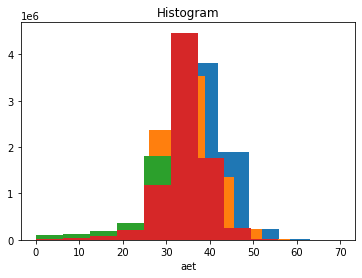

In [38]:
# 2015
aet_d[0:9].plot.hist()
aet_d[9:18].plot.hist()
aet_d[18:27].plot.hist()
aet_d[27:36].plot.hist()

In [39]:
# calculating differences between net water dekadal and net water daily summed
# All of the differences are due to differences between the CHIRPS daily and dekadal precipitation -> different
# methods must have been used to create these two data sets.
# From now on, just using the daily calculated values summed over different periods for consistency.
nw_diffs = []
aet_diffs = []
chirps_diffs = []

for i in range(len(aet_d)):
    start = i*10
    end = start + (dekad_dates[i+1]-dekad_dates[i]).days
    nw_diffs.append(nw_dek[i]-sum(nw_daily[start:end]))
    aet_diffs.append(aet_d[i]-sum(aet_daily[start:end]))
    chirps_diffs.append(chirps_d2[i]-sum(chirps_daily[start:end]))
    
nw_diffs = xr.concat(nw_diffs[:], pd.Index(dekad_dates[:-18], name="time"))
aet_diffs = xr.concat(aet_diffs[:], pd.Index(dekad_dates[:-18], name="time"))
chirps_diffs = xr.concat(chirps_diffs[:], pd.Index(dekad_dates[:-18], name="time"))
#nw_diffs

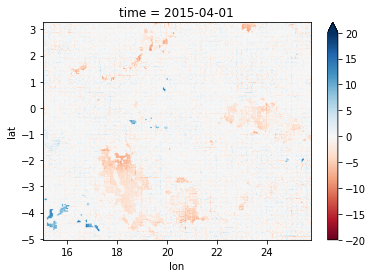

In [40]:
# plotting the daily anomaly between the nw daily sum and dekadal data
nw_diffs[9].plot(cmap='RdBu', vmin=-20, vmax=20)

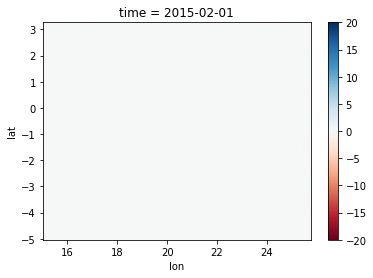

In [41]:
aet_diffs[3].plot(cmap='RdBu', vmin=-20, vmax=20)

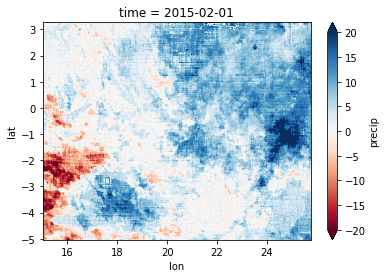

In [42]:
# The CHIRPS daily data summed over 10 days is slightly different from the CHIRPS dekadal data, 
# and this leads to the observed differences between the calculated NWdek and NW daily. 
# Going forward, the daily products will be used. 
chirps_diffs[3].plot(cmap='RdBu', vmin=-20, vmax=20)

## ALOS-2 PALSAR-2 data


### QUICKSTART HERE

- loading daily net water dataset (nw_daily) for the period 2015 to 2021

In [ ]:
# Loading net water data
nw_daily = pkl.load(open(PKL + "nw_daily.pkl", "rb"))
nw_daily['time']

In [6]:
# array of alos2 scene dates within area 2 (the main area for which we have data)
all_dates = ['2019-03-29','2019-05-10','2019-06-21','2019-07-19','2019-08-30','2019-10-11','2019-11-22','2020-01-03','2020-02-14','2020-03-27','2020-05-08','2020-06-19','2020-07-17','2020-08-28','2020-10-09','2021-10-08','2021-11-19']

# converting to the datetime format required for dataframes
all_dates = pd.to_datetime(all_dates)
all_dates

DatetimeIndex(['2019-03-29', '2019-05-10', '2019-06-21', '2019-07-19',
               '2019-08-30', '2019-10-11', '2019-11-22', '2020-01-03',
               '2020-02-14', '2020-03-27', '2020-05-08', '2020-06-19',
               '2020-07-17', '2020-08-28', '2020-10-09', '2021-10-08',
               '2021-11-19'],
              dtype='datetime64[ns]', freq=None)

In [7]:
# reading in ALOS HH and HV - 17 dates for area 2
hh = xr.open_dataset(ALOS + 'Geocoded_HH_area2.nc')
hv = xr.open_dataset(ALOS + 'Geocoded_HV_area2.nc')

In [10]:
%%time
# concatenating the variables along the time dimension
HH = hh.to_array("time", name="Amplitude").to_dataset().assign_coords(time=all_dates)
HV = hv.to_array("time", name="Amplitude").to_dataset().assign_coords(time=all_dates)

In [ ]:
# Check that the output is the digital number (and not normalised)
HH['Amplitude'][0].max()

In [ ]:
%%time

# calculate intensity 
HH['Intensity']=HH['Amplitude']**2
HV['Intensity']=HV['Amplitude']**2

# cross polarisation ratio
HHHV_ratio = HH/HV

# radar vegetation index formula for dual pol
# see: https://rua.ua.es/dspace/bitstream/10045/108088/2/Mandal_etal_2020_RemoteSensEnviron_preprint.pdf
# and Trudel et al. 2012 - specific to HH, HV: 4HV/(HH+HV) - all sigma naught in power units, 
# so apply to intensity values

RVI = 4*HV['Intensity']/(HH['Intensity']+HV['Intensity'])

# Convert to decibels
calibration_factor = -83
HH['db'] = 10*np.log10(HH['Intensity']) + calibration_factor
HV['db'] = 10*np.log10(HV['Intensity']) + calibration_factor
HHHV_ratio['db'] = HH['db'] - HV['db']

In [ ]:
%%time
# calculating normalised version of RVI (this doesn't work out the same as when applying normalisation within SNAP)
# check what kind of normalisation the SNAP method applies
HH_I_norm = norm_to_zero_one(HH['Intensity'])
HV_I_norm = norm_to_zero_one(HV['Intensity'])

RVI_norm = 4*HH_I_norm/(HH_I_norm + HV_I_norm)

In [37]:
# Saving ALOS data (converted to decibels) to netcdf
HH.to_netcdf(path=ALOS_OUT + 'ALOS_HH_area2.nc')
HV.to_netcdf(path=ALOS_OUT+'ALOS_HV_area2.nc')
HHHV_ratio.to_netcdf(path=ALOS_OUT+'ALOS_HHHV_ratio_area2.nc')
RVI.to_netcdf(path=ALOS_OUT+'RVI_area2.nc')

In [ ]:
# calculating min, max, range and stdev across each set of 17 images
# copying just one time step to create a new xarray dataset with the same lat lon dims
HH_stats = HH['db'][0].copy(deep=True,data=None).drop('time')
HH_stats['stdev'] = HH['db'].std(dim='time')
HH_stats['min'] = HH['db'].min(dim='time')
HH_stats['max'] = HH['db'].max(dim='time')
HH_stats['range'] = HH_stats['max']-HH_stats['min']

# saving to netcdf
HH_stats.to_netcdf(path=ALOS_OUT + 'ALOS_HH_area2_stats.nc')

In [ ]:
# HV stats
HV_stats = HV['db'][0].copy(deep=True,data=None).drop('time')
HV_stats['stdev'] = HV['db'].std(dim='time')
HV_stats['min'] = HV['db'].min(dim='time')
HV_stats['max'] = HV['db'].max(dim='time')
HV_stats['range'] = HV_stats['max']-HV_stats['min']

# saving to netcdf
HV_stats.to_netcdf(path=ALOS_OUT + 'ALOS_HV_area2_stats.nc')

In [ ]:
# HHHV_ratio stats
HHHV_ratio_stats = HHHV_ratio['db'][0].copy(deep=True,data=None).drop('time')
HHHV_ratio_stats['stdev'] = HHHV_ratio['db'].std(dim='time')
HHHV_ratio_stats['min'] = HHHV_ratio['db'].min(dim='time')
HHHV_ratio_stats['max'] = HHHV_ratio['db'].max(dim='time')
HHHV_ratio_stats['range'] = HHHV_ratio_stats['max']-HHHV_ratio_stats['min']

# saving to netcdf
HHHV_ratio_stats.to_netcdf(path=ALOS_OUT + 'ALOS_HHHV_ratio_area2_stats.nc')

In [ ]:
# RVI stats
RVI_stats = RVI[0].copy(deep = True,data = None).drop('time')
RVI_stats['stdev'] = RVI.std(dim ='time')
RVI_stats['min'] = RVI.min(dim ='time')
RVI_stats['max'] = RVI.max(dim ='time')
RVI_stats['range'] = RVI_stats['max'] - RVI_stats['min']

# saving to netcdf
RVI_stats.to_netcdf(path = ALOS_OUT + 'ALOS_RVI_area2_stats.nc')